In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse as sp
from scipy.sparse import linalg
from math import *
from PIL import Image

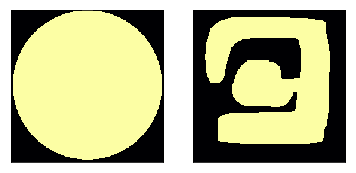

In [2]:
fullrect = np.array( Image.open('fullrect.png') )[:,:,0]/255.
bounded = np.array( Image.open('bounded.png') )[:,:,0]/255.
comp = np.array ( Image.open('complex.png') )[:,:,0]/255.

arr = np.zeros(fullrect.shape)
N = arr.shape[0]
h = 1/arr.shape[0]
dx = 1/h
xr, yr = np.linspace(0,1,N), np.linspace(0,1,N)
x, y = np.meshgrid(xr, yr)

idx = np.zeros(arr.shape).astype(int) -1
nowidx = 0
for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        idx[i,j] = nowidx
        nowidx += 1

def draw(img, vmax=None, cmap=plt.cm.inferno):
    plt.imshow(img.reshape(N,N), cmap=cmap, vmin=0, vmax=vmax); plt.xticks([]); plt.yticks([])
plt.subplot(121); draw(bounded)
plt.subplot(122); draw(comp)

# Operator

In [3]:
def Laplacian(arr):
    # Absorbing boundary
    row, col, data = [], [], []
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if(arr[i,j]>0):
                row.append(idx[i,j]); col.append(idx[i,j]); data.append(-4*dx*dx);
                if(arr[(i+1)%N,j]>0):
                    row.append(idx[i,j]); col.append(idx[(i+1)%N,j]); data.append(dx*dx);
                if(arr[i-1,j]>0):
                    row.append(idx[i,j]); col.append(idx[i-1,j]); data.append(dx*dx);
                if(arr[i,(j+1)%N]>0):
                    row.append(idx[i,j]); col.append(idx[i,(j+1)%N]); data.append(dx*dx);
                if(arr[i,j-1]>0):
                    row.append(idx[i,j]); col.append(idx[i,j-1]); data.append(dx*dx);
    return sp.csr_matrix((data, (row, col)), shape=(N*N, N*N))

def Laplacian_ref(arr):
    # Open boundary
    row, col, data = [], [], []
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if(arr[i,j]>0):
                row.append(idx[i,j]); col.append(idx[i,j]); data.append(-4*dx*dx);
                if(arr[(i+1)%N,j]>0 and arr[i-1,j]>0):
                    row.append(idx[i,j]); col.append(idx[(i+1)%N,j]); data.append(dx*dx);
                    row.append(idx[i,j]); col.append(idx[i-1,j]); data.append(dx*dx);
                elif( arr[(i+1)%N,j] == 0 ):
                    row.append(idx[i,j]); col.append(idx[i-1,j]); data.append(2*dx*dx);
                elif( arr[i-1,j] == 0 ):
                    row.append(idx[i,j]); col.append(idx[(i+1)%N,j]); data.append(2*dx*dx);
                if(arr[i,(j+1)%N]>0 and arr[i,j-1]>0):
                    row.append(idx[i,j]); col.append(idx[i,(j+1)%N]); data.append(dx*dx);
                    row.append(idx[i,j]); col.append(idx[i,j-1]); data.append(dx*dx);
                elif( arr[i,(j+1)%N] == 0 ):
                    row.append(idx[i,j]); col.append(idx[i,j-1]); data.append(2*dx*dx);
                elif( arr[i,j-1] == 0 ):
                    row.append(idx[i,j]); col.append(idx[i,(j+1)%N]); data.append(2*dx*dx);
    return sp.csr_matrix((data, (row, col)), shape=(N*N, N*N))

# Forward Euler

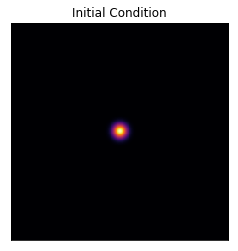

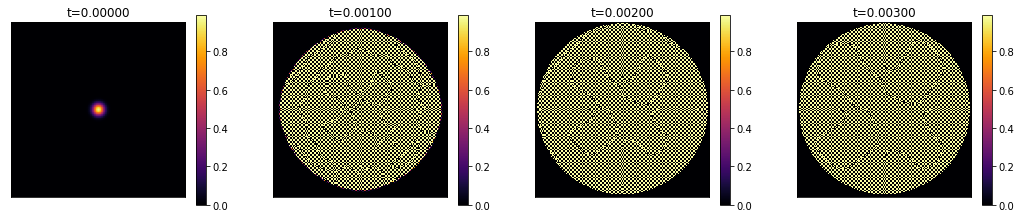

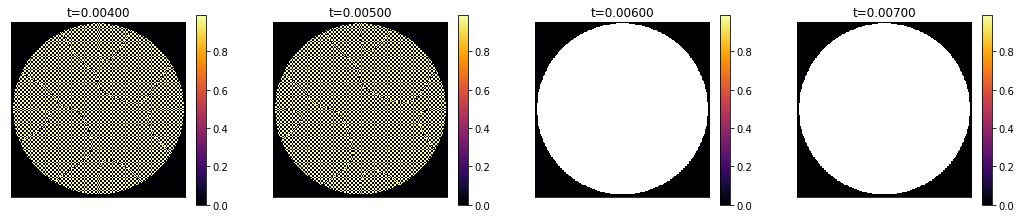

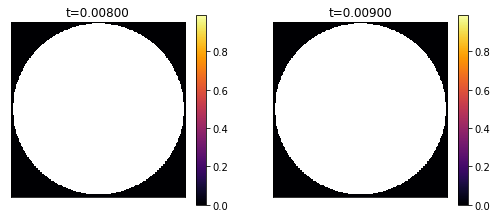

In [6]:
h = 1/arr.shape[0]
dx = 1/h
dt = 0.00001
domain = bounded

op = sp.identity(N*N) + dt * Laplacian(domain)
P = np.exp( 1000*(-(x-0.5)**2-(y-0.5)**2) ) * domain
P = P.flatten()
vmax = np.max(P)
draw(P); plt.title('Initial Condition'); plt.show()
i = 0

for t in range(1000):
    P = op.dot(P)
    if t%100==0:
        if i%4 == 0 : plt.figure(figsize=(18,3.5))
        plt.subplot(1,4,i%4+1)
        plt.title('t=%.5f'%(dt*t));
        draw(P, vmax); plt.colorbar();
        i += 1
        if i%4 == 0 : plt.show()

# Backward Euler

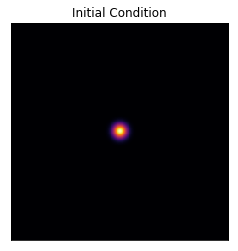

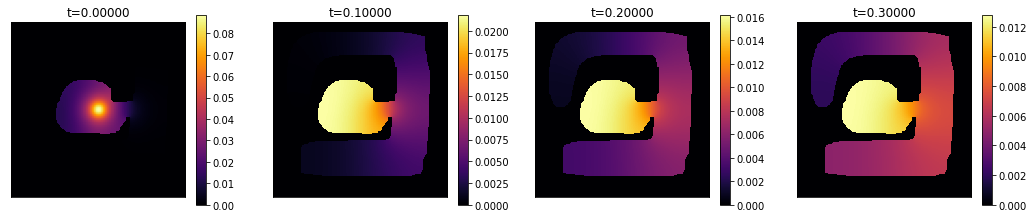

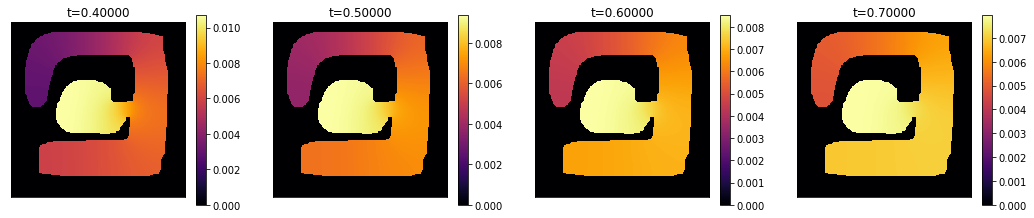

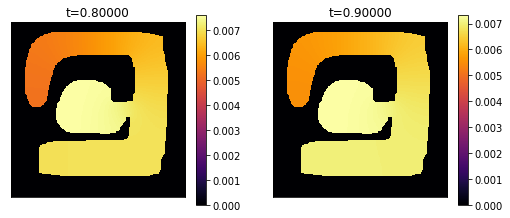

In [10]:
h = 1/arr.shape[0]
dx = 1/h
dt = 0.01
domain = comp

op = sp.identity(N*N) - dt * Laplacian_ref(domain)
LU = sp.linalg.splu(op)
P = np.exp( 1000*(-(x-0.5)**2-(y-0.5)**2) ) * domain
P = P.flatten().astype(np.float64)
vmax = np.max(P)
draw(P); plt.title('Initial Condition'); plt.show()
i = 0

for t in range(100):
    P = LU.solve(P)
    if t%10==0:
        if i%4 == 0 : plt.figure(figsize=(18,3.5))
        plt.subplot(1,4,i%4+1)
        plt.title('t=%.5f'%(dt*t));
        draw(P); plt.colorbar();
        i += 1
        if i%4 == 0 : plt.show()

# Turing Pattern

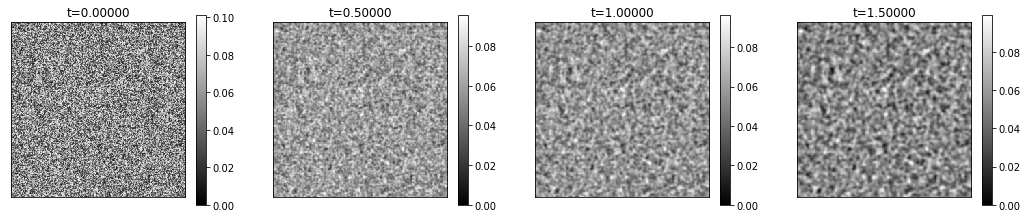

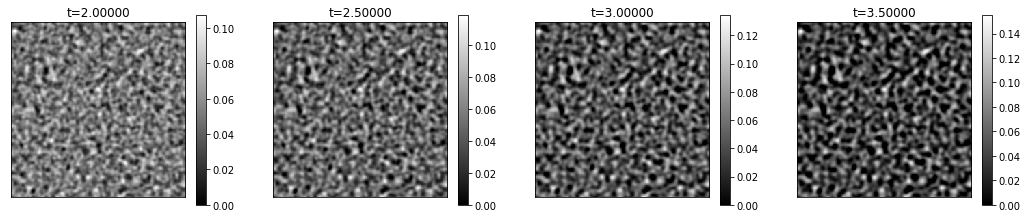

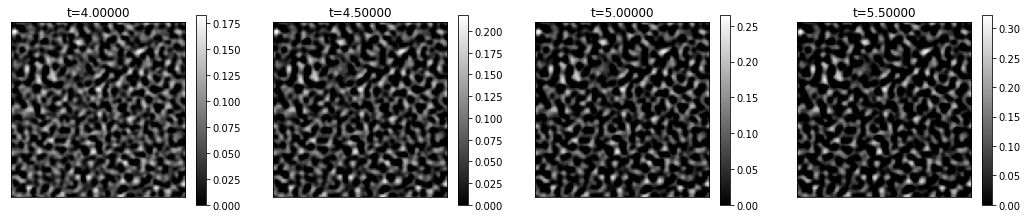

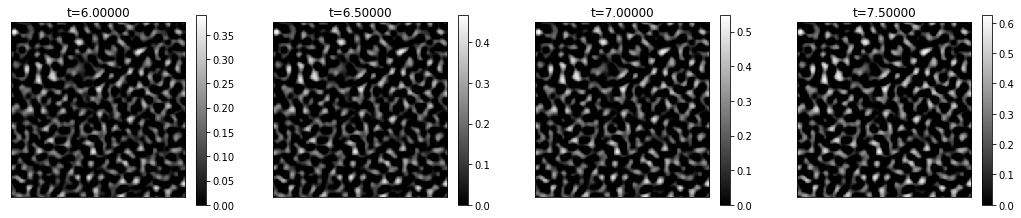

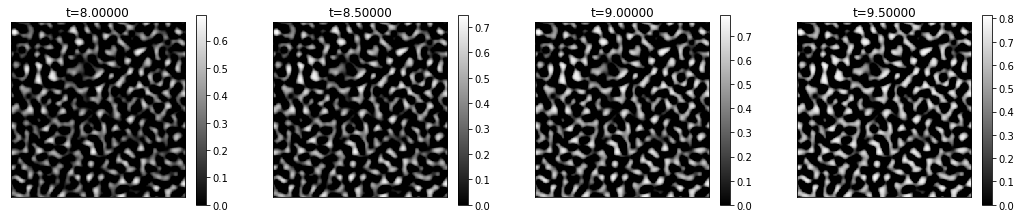

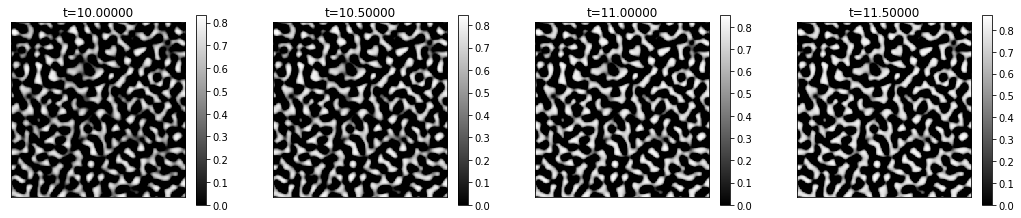

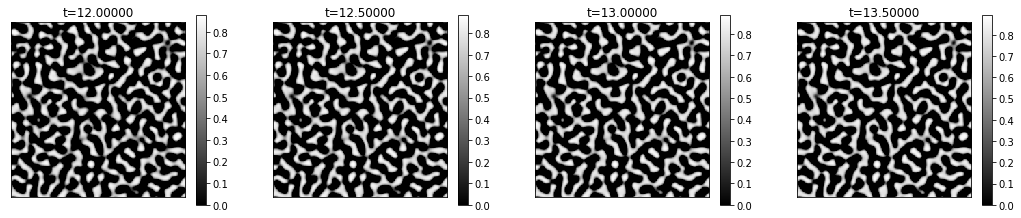

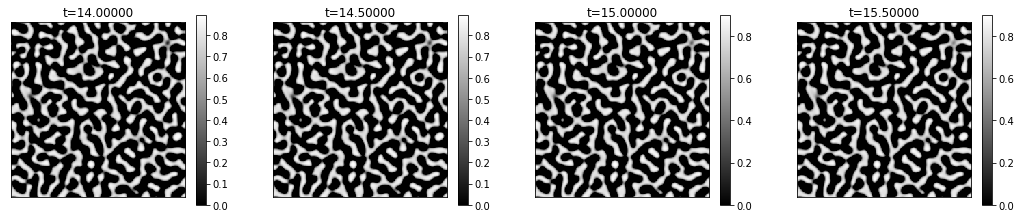

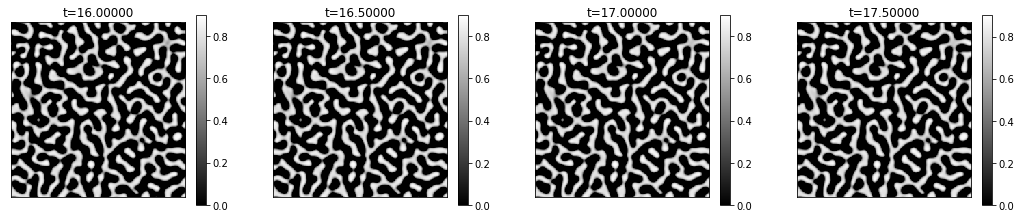

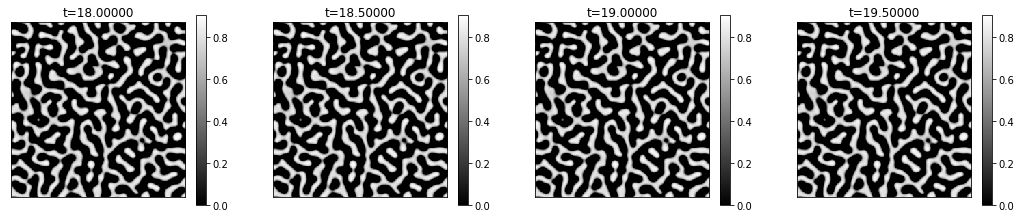

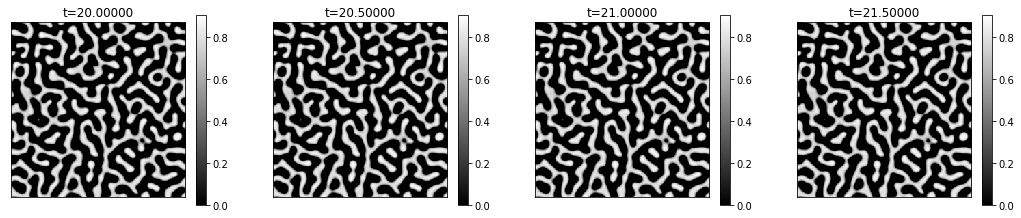

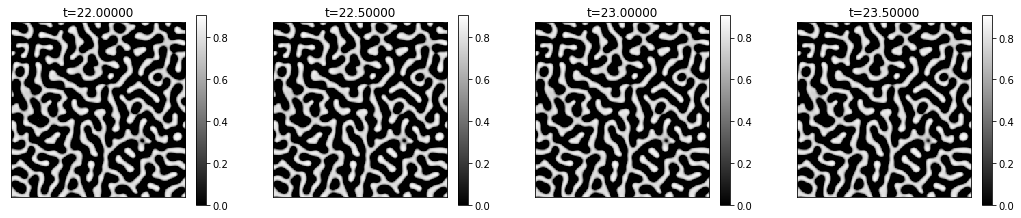

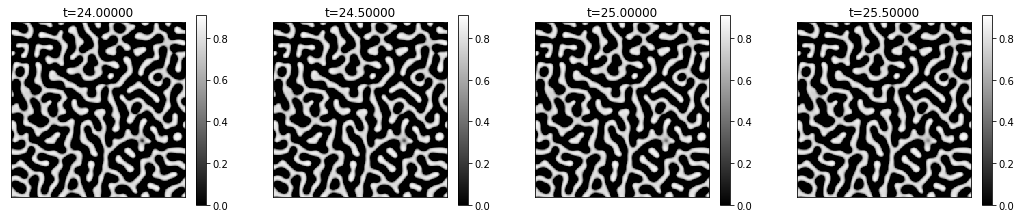

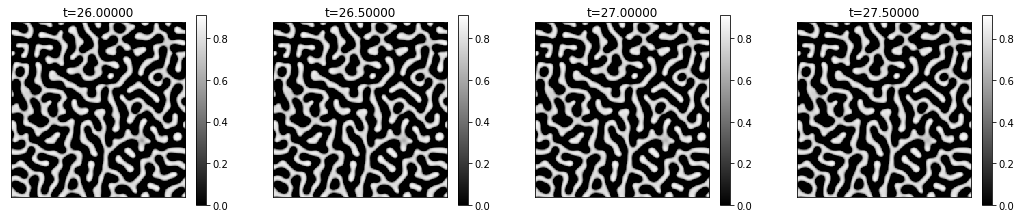

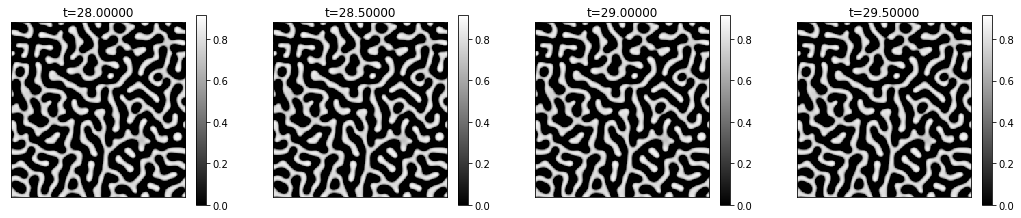

In [13]:
h = 200/arr.shape[0]
dx = 1/h
dt = 0.1
alpha, beta, e, delta = -0.005, 5, 0.05, 100
domain = fullrect

opA = sp.identity(N*N) - dt * Laplacian(domain)
opB = sp.identity(N*N) - dt * delta * Laplacian(domain)
LUA, LUB = sp.linalg.splu(opA), sp.linalg.splu(opB)

A = np.random.rand(*domain.shape)*domain*0.1
B = np.zeros(A.shape)
A, B = A.flatten(), B.flatten()

i = 0
for t in range(300):
    A += dt * (A-A**3-B)
    B += dt * beta * (A-B-alpha)
    A, B = LUA.solve(A), LUB.solve(B)
    if t%5==0:
        if i%4 == 0 : plt.figure(figsize=(18,3.5))
        plt.subplot(1,4,i%4+1)
        plt.title('t=%.5f'%(dt*t));
        draw(A, cmap=plt.cm.gray); plt.colorbar();
        i += 1
        if i%4 == 0 : plt.show()